In [ ]:
import json 
import numpy as np
data = []
data_dict = {'EventID':None, 'PDG':None, 'NHits':None, 'BarID':None, 'P':None, 'Theta':None, 'Phi':None, 'X':None, 'Y':None, 'Z':None, 'pmtID':None, 'pixelID':None, 'channel':None, 'leadTime':None}
EventID = []
PDG = []
NHits = []
BarID = []
P = []
Theta = []
Phi = []
X = []
Y = []
Z = []
pmtID = []
pixelID = []
channel = []
leadTime = []
i = 0
with open(r"C:\Users\James-PC\James\EIC\Cherenkov_Workspace\Phi.json") as f:
    for line in f:
        #data.append(json.loads(line))
        data = json.loads(line)
        EventID.append(data['EventID'])
        PDG.append(data['PDG'])
        NHits.append(data['NHits'])
        BarID.append(data['BarID'])
        P.append(data['P'])
        Theta.append(data['Theta'])
        Phi.append(data['Phi'])
        X.append(data['X'])
        Y.append(data['Y'])
        Z.append(data['Z'])
        pmtID.append(data['pmtID'])
        pixelID.append(data['pixelID'])
        channel.append(data['channel'])
        leadTime.append(data['leadTime'])
        i+= 1
        
        #if i == 10:
        #    break
        

data_dict['EventID']  =      np.array(EventID)
data_dict['PDG']  =        np.array(PDG)
data_dict['NHits']  =        np.array(NHits)
data_dict['BarID']  =        np.array(BarID)
data_dict['P']  =        np.array(P)
data_dict['Theta']  =        np.array(Theta)
data_dict['Phi']  =        np.array(Phi)
data_dict['X']  =        np.array(X)
data_dict['Y']  =        np.array(Y)
data_dict['Z']  =        np.array(Z)
data_dict['pmtID']  =        pmtID
data_dict['pixelID']  =        pixelID
data_dict['channel']  =        channel
data_dict['leadTime']  =        leadTime      

print(" Done " )

In [ ]:
clean_events = []
PIDS = [-321,321] # You need to change this for Phi (K+,K-,321,-321) or Rho (pi+,pi-, 211,-22) decays
event_with_other_PID = 0
conditional_maxes = np.array([8.5,11.63,175.5])
conditional_mins = np.array([0.95,0.90,-176.])
for j in np.unique(data_dict['EventID']):
    if j % 10000 == 0:
        print(j)
    
    idx = np.where(data_dict['EventID'] == j)[0]
    ys = data_dict['Y'][idx]
    if len(idx) > 2:
        print('Skipping event.')
        
    if len(idx) > 1:
        if (ys[0] > 0) and (ys[1] > 0):
            continue
        elif (ys[0] < 0) and (ys[1] < 0):
            continue
        else:
            temp_oboxes = np.array(data_dict['pmtID'][idx[0]])//108
            #print(temp_oboxes)
            hits_in_obox0 = np.where(temp_oboxes == 0)[0]
            hits_in_obox1 = np.where(temp_oboxes == 1)[0]
            obox_0_idx = np.where(data_dict['Y'][idx] < 0)[0][0]
            obox_1_idx = np.where(data_dict['Y'][idx] > 0)[0][0]
            
            pmt_obox_0 = np.array(data_dict['pmtID'][idx[0]])[hits_in_obox0]
            pmt_obox_1 = np.array(data_dict['pmtID'][idx[0]])[hits_in_obox1]
            pixel_obox_0 = np.array(data_dict['pixelID'][idx[0]])[hits_in_obox0]
            pixel_obox_1 = np.array(data_dict['pixelID'][idx[0]])[hits_in_obox1]
            leadTime_obox_0 = np.array(data_dict['leadTime'][idx[0]])[hits_in_obox0]
            leadTime_obox_1 = np.array(data_dict['leadTime'][idx[0]])[hits_in_obox1]
            channel_obox_0 = np.array(data_dict['channel'][idx[0]])[hits_in_obox0]
            channel_obox_1 = np.array(data_dict['channel'][idx[0]])[hits_in_obox1]
            
            #print(pmt_obox_0)
            
            
            event0 = {'EventID':idx[0], 'PDG':data_dict['PDG'][idx][obox_0_idx], 'NHits':len(pmt_obox_0), 'BarID':data_dict['BarID'][idx][obox_0_idx], 'P':data_dict['P'][idx][obox_0_idx], 'Theta':data_dict['Theta'][idx][obox_0_idx], 'Phi':data_dict['Phi'][idx][obox_0_idx], 'X':data_dict['X'][idx][obox_0_idx], 'Y':data_dict['Y'][idx][obox_0_idx], 'Z':data_dict['Z'][idx][obox_0_idx],
                      'pmtID':pmt_obox_0, 'pixelID':pixel_obox_0, 'channel':channel_obox_0, 'leadTime':leadTime_obox_0}
            event1 = {'EventID':idx[0], 'PDG':data_dict['PDG'][idx][obox_1_idx], 'NHits':len(pmt_obox_1), 'BarID':data_dict['BarID'][idx][obox_1_idx], 'P':data_dict['P'][idx][obox_1_idx], 'Theta':data_dict['Theta'][idx][obox_1_idx], 'Phi':data_dict['Phi'][idx][obox_1_idx], 'X':data_dict['X'][idx][obox_1_idx], 'Y':data_dict['Y'][idx][obox_1_idx], 'Z':data_dict['Z'][idx][obox_1_idx],
                      'pmtID':pmt_obox_1, 'pixelID':pixel_obox_1, 'channel':channel_obox_1, 'leadTime':leadTime_obox_1}
            
        if (event0['PDG'] in PIDS) and (len(pmt_obox_0) < 300) and (event0['P'] < conditional_maxes[0]) and (event0['P'] > conditional_mins[0]) and (event0['Theta'] < conditional_maxes[1]) and (event0['Theta'] > conditional_mins[1]) and (event0['Phi'] < conditional_maxes[2]) and (event0['Phi'] > conditional_mins[2]):
            clean_events.append(event0)
        if (event1['PDG'] in PIDS) and (len(pmt_obox_1) < 300)  and (event1['P'] < conditional_maxes[0]) and (event1['P'] > conditional_mins[0]) and (event1['Theta'] < conditional_maxes[1]) and (event1['Theta'] > conditional_mins[1]) and (event1['Phi'] < conditional_maxes[2]) and (event1['Phi'] > conditional_mins[2]):
            clean_events.append(event1)
        if event1['PDG'] not in PIDS or event0['PDG'] not in PIDS:
            event_with_other_PID +=1
            
    else:
        if (data_dict['PDG'][idx] in PIDS) and (data_dict['P'][idx] < conditional_maxes[0]) and (data_dict['P'][idx] > conditional_mins[0]) and (data_dict['Theta'][idx] < conditional_maxes[1]) and (data_dict['Theta'][idx] > conditional_mins[1]) and (data_dict['Phi'][idx] < conditional_maxes[2]) and (data_dict['Phi'][idx] > conditional_mins[2]) :
            idx = idx[0]
            temp_oboxes = np.array(data_dict['pmtID'][idx])//108
            if len(np.unique(temp_oboxes)) > 1:
                y = data_dict['Y'][idx]
                if y < 0:
                    hits_in_obox = np.where(temp_oboxes == 0)[0]
                elif y > 0:
                    hits_in_obox = np.where(temp_oboxes == 1)[0]
                    
                pmt_obox = np.array(data_dict['pmtID'][idx])[hits_in_obox]
                pixel_obox = np.array(data_dict['pixelID'][idx])[hits_in_obox]
                leadTime_obox = np.array(data_dict['leadTime'][idx])[hits_in_obox]
                channel_obox = np.array(data_dict['channel'][idx])[hits_in_obox]
                
                event = {'EventID':idx, 'PDG':data_dict['PDG'][idx], 'NHits':len(pmt_obox), 'BarID':data_dict['BarID'][idx], 'P':data_dict['P'][idx], 'Theta':data_dict['Theta'][idx], 'Phi':data_dict['Phi'][idx], 'X':data_dict['X'][idx], 'Y':data_dict['Y'][idx], 'Z':data_dict['Z'][idx],
                      'pmtID':pmt_obox, 'pixelID':pixel_obox, 'channel':channel_obox, 'leadTime':leadTime_obox}
                     
            else:  
                event = {'EventID':idx, 'PDG':data_dict['PDG'][idx], 'NHits':data_dict['NHits'][idx], 'BarID':data_dict['BarID'][idx], 'P':data_dict['P'][idx], 'Theta':data_dict['Theta'][idx], 'Phi':data_dict['Phi'][idx], 'X':data_dict['X'][idx], 'Y':data_dict['Y'][idx], 'Z':data_dict['Z'][idx],
                          'pmtID':data_dict['pmtID'][idx], 'pixelID':data_dict['pixelID'][idx], 'channel':data_dict['channel'][idx], 'leadTime':data_dict['leadTime'][idx]}
                
            clean_events.append(event)

print('Done.')

In [1]:
from torch.utils.data import Dataset
import numpy as np
import os
import torch
import random
import collections


class DIRC_Dataset(Dataset):

    def __init__(self,data,stats={"x_max": 892,"x_min":0,"y_max":292,"y_min":0,"time_max":500.00,"time_min":0.0}):
        self.data = data
        self.stats = stats

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        # ['EventID','PDG','NHits','BarID','P','Theta','Phi','X','Y','Z',
        # 'pmtID','pixelID','channel'','leadTime']

        # Get the sample
        data = self.data[idx]
        
        PID = data['PDG']
        barID = data['BarID']
        barX = data['X']
        barY = data['Y']
        pmtID = np.array(data['pmtID'])
        event_num = data['EventID']
        o_box = pmtID//108
        
#         conditional_maxes = [8.5,11.63,175.5]
#         conditional_mins = [0.95,0.90,-176.]
        
#         if data['P'] > 8.5 or data['Theta'] > 11.63 or data['Phi'] > 175.5:
#             return 0,0,0,0,-1
        
#         if data['P'] < 0.95 or data['Theta'] < 0.90 or data['Phi'] < -176:
#             return 0,0,0,0,-1
        
#         if ((data['P'] > 5.) or (data['P'] < 3.) or (data['Theta'] < 2.0) or (data['Theta'] > 6)):
#             return 0,0,0,0,-1

        if o_box[0] == 1:
            pmtID -= 108

        if len(np.unique(o_box)) != 1:
            print(np.unique(o_box))

        pixelID = np.array(data['pixelID'])

        row = (pmtID//18) * 8 + pixelID//8
        col = (pmtID%18) * 8 + pixelID%8

        time = np.array(data['leadTime'])

        pos_time = np.where((time > 0) & (time < 500))[0]
        row = row[pos_time]
        col = col[pos_time]
        time = time[pos_time]
        pmtID = pmtID[pos_time]
        

        assert len(row) == len(time)

        x = col * 6 + (pmtID % 18) * 2 + 3# + np.random.uniform(-3,3)
        y = row * 6 + (pmtID // 18) * 2 + 3# + np.random.uniform(-3,3,random)

        # Apply MinMax Scaling on (-1,1)
        #x = 2.0 * (x - self.stats['x_min'])/(self.stats['x_max'] - self.stats['x_min']) - 1.0
        #y = 2.0 * (y - self.stats['y_min'])/(self.stats['y_max'] - self.stats['y_min']) - 1.0
        #time = 2.0 * (time - self.stats['time_min'])/(self.stats['time_max'] - self.stats['time_min']) - 1.0

        if abs(PID) == 211: # 211 is Pion from rho decay
            PID = 1
        elif abs(PID) == 321: # 321 is Kaon from phi decay
            PID = 0
        else:
            return 0,0,0,0,-1
            #print("Ambiguous final state {0}. Check event {1}".format(PID,idx))
            
        barID = np.ones_like(pmtID) * barID
        barX = np.ones_like(pmtID) * barX
        barY = np.ones_like(pmtID) * barY
        #eventID = np.ones_like(pmtID) * event_num
        
        metadata = np.concatenate([np.c_[barID],np.c_[barX],np.c_[barY]],axis=1)
    
        cond = np.array([data['P'],data['Theta'],data['Phi']])
        cond = cond.reshape(1,-1).repeat(len(x),0)
        hits = np.concatenate([np.c_[x],np.c_[y],np.c_[time]],axis=1)
        return hits,cond,metadata,event_num,1


C:\Users\James\.conda\envs\ptorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
rho_train = np.load(r"Training_Pions_From_Rho_April3_2024.pkl",allow_pickle=True)
rho_test = np.load(r"Testing_Pions_From_Rho_April3_2024.pkl",allow_pickle=True)
rho_val = np.load(r"Validation_Pions_From_Rho_April3_2024.pkl",allow_pickle=True)

In [34]:
dataset = DIRC_Dataset(phi)

In [35]:
hits = []
conditions = []
metadata = []
events_dict = []
eventIDs = []

for i in range(len(dataset)):
    if i % 100000 == 0:
        print(i)
    h,cond,meta,eventID,status = dataset.__getitem__(i)
    
    if status == -1:
        print('Rejection.')
        continue
#     dicte = {"EventID":eventID,"hits":h,"conditions":cond,"meta":meta}
#     events_dict.append(dicte)
    hits.append(h)
    conditions.append(cond)
    metadata.append(meta)
    eventIDs.append(eventID * np.ones_like(cond[:,0]))

0


In [9]:
import pandas as pd
def to_csv(file_path,hits,conds,meta):
    hits = np.concatenate(hits)
    conds = np.concatenate(conds)
    meta = np.concatenate(meta)
    print(hits.shape,conds.shape,meta.shape)
    hits_frame = pd.DataFrame(np.concatenate([hits,conds,meta],axis=1),columns=["x","y","time","P","theta","phi","barID","barX","barY"])
    hits_frame.to_csv(file_path,sep=',',index=None)

In [36]:
to_csv("Testing_Hit_Level_Kaons_from_Phi_April4.csv",hits,conditions,metadata)

(4232618, 3) (4232618, 3) (4232618, 3)


In [9]:
# Make presmeared training sets:
import pandas as pd

df = pd.read_csv("Training_Hit_Level_Pions_from_Rho_April4.csv",sep=',',index_col=None)
df

,x,y,time,P,theta,phi,barID,barX,barY
0,65.0,103.0,71.0158,5.176939,8.464703,-28.712934,7.0,66.857468,-36.426823
1,9.0,77.0,124.1070,5.176939,8.464703,-28.712934,7.0,66.857468,-36.426823
2,289.0,77.0,71.8398,5.176939,8.464703,-28.712934,7.0,66.857468,-36.426823
3,621.0,27.0,76.2109,5.176939,8.464703,-28.712934,7.0,66.857468,-36.426823
4,809.0,95.0,93.5656,5.176939,8.464703,-28.712934,7.0,66.857468,-36.426823
...,...,...,...,...,...,...,...,...,...
54607382,545.0,89.0,72.2719,1.547866,8.276694,72.687820,40.0,24.395369,75.264526
54607383,877.0,139.0,43.0832,1.547866,8.276694,72.687820,40.0,24.395369,75.264526
54607384,215.0,109.0,82.6341,1.547866,8.276694,72.687820,40.0,24.395369,75.264526
54607385,671.0,95.0,73.1537,1.547866,8.276694,72.687820,40.0,24.395369,75.264526


In [10]:
import numpy as np

df['x'] = df['x'] + np.random.uniform(-3,3,size=df['x'].to_numpy().shape)
df['y'] = df['y'] + np.random.uniform(-3,3,size=df['y'].to_numpy().shape)
df

,x,y,time,P,theta,phi,barID,barX,barY
0,65.635962,100.542830,71.0158,5.176939,8.464703,-28.712934,7.0,66.857468,-36.426823
1,9.273720,76.234025,124.1070,5.176939,8.464703,-28.712934,7.0,66.857468,-36.426823
2,288.490766,74.305627,71.8398,5.176939,8.464703,-28.712934,7.0,66.857468,-36.426823
3,619.539340,27.186588,76.2109,5.176939,8.464703,-28.712934,7.0,66.857468,-36.426823
4,808.100248,97.300905,93.5656,5.176939,8.464703,-28.712934,7.0,66.857468,-36.426823
...,...,...,...,...,...,...,...,...,...
54607382,542.726739,89.840882,72.2719,1.547866,8.276694,72.687820,40.0,24.395369,75.264526
54607383,878.364332,137.267881,43.0832,1.547866,8.276694,72.687820,40.0,24.395369,75.264526
54607384,217.804773,108.736209,82.6341,1.547866,8.276694,72.687820,40.0,24.395369,75.264526
54607385,673.922718,96.368274,73.1537,1.547866,8.276694,72.687820,40.0,24.395369,75.264526


In [11]:
df.to_csv("Training_Hit_Level_Pions_from_Rho_April4_Smeared.csv",sep=',',index=None)

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>,
        <AxesSubplot:title={'center':'time'}>],
       [<AxesSubplot:title={'center':'P'}>,
        <AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'phi'}>],
       [<AxesSubplot:title={'center':'barID'}>,
        <AxesSubplot:title={'center':'barX'}>,
        <AxesSubplot:title={'center':'barY'}>]], dtype=object)

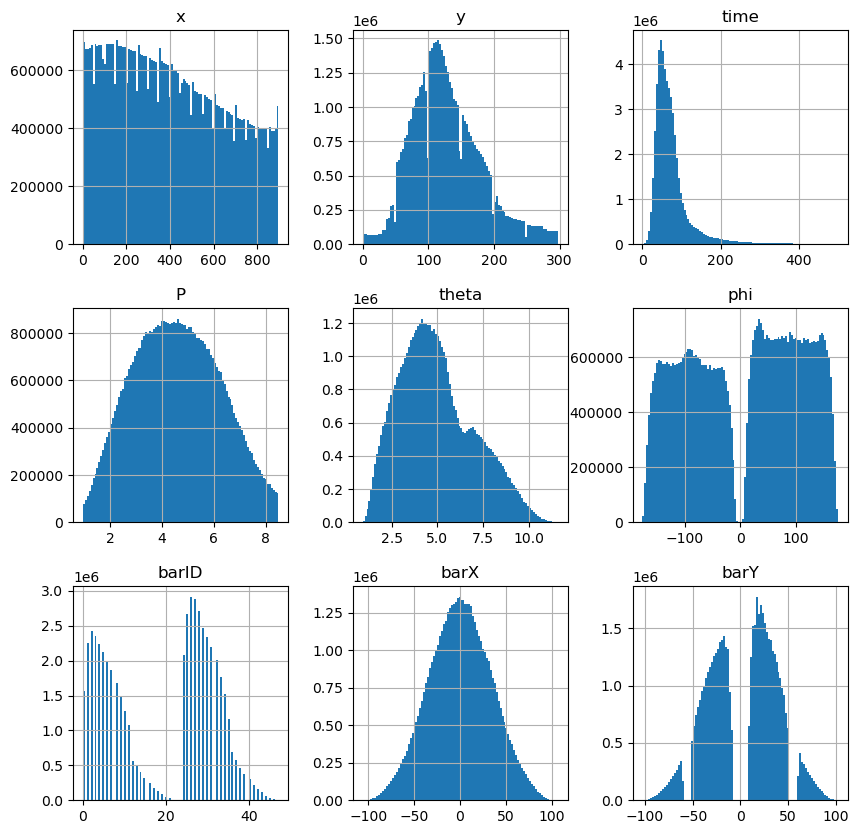

In [12]:
df.hist(figsize=(10,10),bins=100)